En este proyecto, vamos a utilizar el conjunto de datos de acciones de MasterCard de Kaggle del 25 de mayo de 2006 al 11 de octubre de 2021 y a entrenar los modelos LSTM y GRU para predecir el precio de las acciones. En este proyecto introductorio al análisis de series temporales mediante RNN; analizaremos datos, los preprocesaremos para entrenarlos con modelos RNN avanzados y, por último, evaluaremos los resultados.

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, Input
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed

set_seed(455)
np.random.seed(455)

## Análisis de datos
En esta parte, importaremos el conjunto de datos MasterCard añadiendo la columna Date al índice y convirtiéndola al formato DateTime. También eliminaremos las columnas irrelevantes del conjunto de datos, ya que solo nos interesan los precios de las acciones, el volumen y la fecha.

El conjunto de datos tiene Date como índice y Open, High, Low, Close y Volume como columnas. Parece que hemos importado correctamente un conjunto de datos limpio.

In [30]:
dataset = pd.read_csv("Mastercard_stock_history.csv", index_col="Date", parse_dates=["Date"]).drop(["Dividends", "Stock Splits"], axis=1)
print(dataset.head())

                Open      High       Low     Close     Volume
Date                                                         
2006-05-25  3.748967  4.283869  3.739664  4.279217  395343000
2006-05-26  4.307126  4.348058  4.103398  4.179680  103044000
2006-05-30  4.183400  4.184330  3.986184  4.093164   49898000
2006-05-31  4.125723  4.219679  4.125723  4.180608   30002000
2006-06-01  4.179678  4.474572  4.176887  4.419686   62344000


La función .describe() nos ayuda a analizar los datos en profundidad. Vamos a centrarnos en la columna High, ya que vamos a utilizarla para entrenar el modelo. También podemos elegir las columnas Close u Open para una característica del modelo, pero High tiene más sentido, ya que nos proporciona información de lo alto que subieron los valores de la acción en un día determinado.

In [31]:
print(dataset.describe())

              Open         High          Low        Close        Volume
count  3872.000000  3872.000000  3872.000000  3872.000000  3.872000e+03
mean    104.896814   105.956054   103.769349   104.882714  1.232250e+07
std     106.245511   107.303589   105.050064   106.168693  1.759665e+07
min       3.748967     4.102467     3.739664     4.083861  6.411000e+05
25%      22.347203    22.637997    22.034458    22.300391  3.529475e+06
50%      70.810079    71.375896    70.224002    70.856083  5.891750e+06
75%     147.688448   148.645373   146.822013   147.688438  1.319775e+07
max     392.653890   400.521479   389.747812   394.685730  3.953430e+08


El precio mínimo de las acciones es de 4,10$ y el máximo es de 400,5$. La media está en 105,9$ y la desviación típica, en 107,3$, lo que significa que las acciones tienen una varianza elevada.

Utilizando .isna().sum() podemos determinar los valores que faltan en el conjunto de datos. Parece que en el conjunto de datos no falta ningún valor.

In [32]:
dataset.isna().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

La función train_test_plot toma tres argumentos: dataset, tstart y tend, y traza un gráfico de líneas sencillo. tstart y tend son límites de tiempo en años. Podemos cambiar estos argumentos para analizar periodos concretos. El gráfico de líneas se divide en dos partes: entrenamiento y prueba. Esto nos permitirá decidir la distribución del conjunto de datos de prueba.

El precio de las acciones de MasterCard lleva subiendo desde 2016. Tuvo un bajón en el primer trimestre de 2020, pero se estabilizó en la segunda mitad del año. Nuestro conjunto de datos de prueba consta de un año, de 2021 a 2022, y el resto del conjunto de datos se utiliza para el entrenamiento.

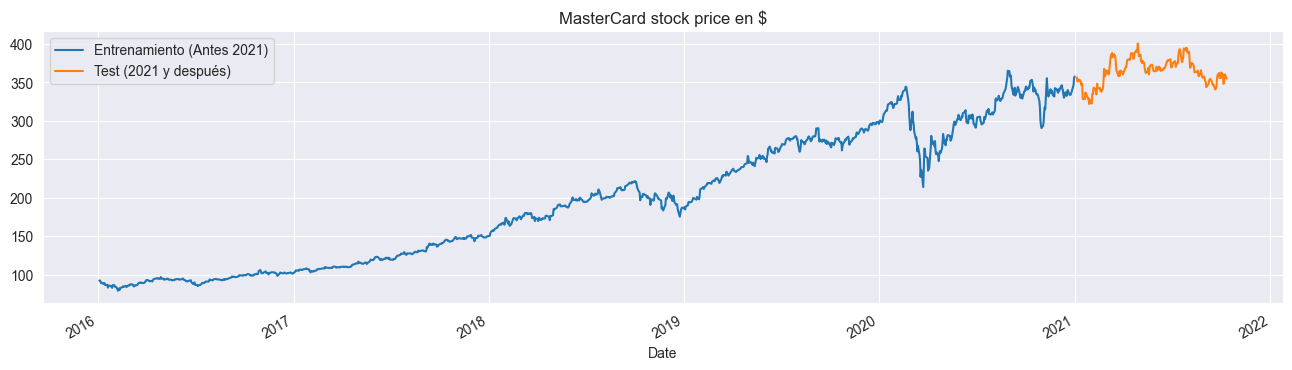

In [33]:
tstart = 2016
tend = 2020

# Explicar diferencia con iloc

def train_test_plot(dataset, tstart, tend):
    dataset.loc[f"{tstart}":f"{tend}", "High"].plot(figsize=(16, 4), legend=True)
    dataset.loc[f"{tend+1}":, "High"].plot(figsize=(16, 4), legend=True)
    plt.legend([f"Entrenamiento (Antes {tend+1})", f"Test ({tend+1} y después)"])
    plt.title("MasterCard stock price en $")
    plt.show()

train_test_plot(dataset,tstart,tend)

## Preprocesamiento de datos
La función train_test_split divide el conjunto de datos en dos subconjuntos: training_set y test_set.

In [34]:
def train_test_split(dataset, tstart, tend):
    train = dataset.loc[f"{tstart}":f"{tend}", "High"].values
    test = dataset.loc[f"{tend+1}":, "High"].values
    return train, test

training_set, test_set = train_test_split(dataset, tstart, tend)

Utilizaremos la función MinMaxScaler para estandarizar nuestro conjunto de entrenamiento, lo que nos ayudará a evitar los valores atípicos o anomalías. También puedes probar a utilizar StandardScaler o cualquier otra función escalar para normalizar tus datos y mejorar el rendimiento del modelo.

In [35]:
training_set.shape

(1259,)

In [36]:
training_set

array([ 92.14629264,  92.37765141,  91.1718942 , ..., 347.0476288 ,
       356.07333066, 357.6556067 ])

In [37]:
sc = MinMaxScaler(feature_range=(0, 1))
training_set = training_set.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)

In [38]:
training_set.shape

(1259, 1)

In [39]:
training_set

array([[ 92.14629264],
       [ 92.37765141],
       [ 91.1718942 ],
       ...,
       [347.0476288 ],
       [356.07333066],
       [357.6556067 ]])

La función split_sequence utiliza un conjunto de datos de entrenamiento y lo convierte en entradas (X_train) y salidas (y_train).

Por ejemplo, si la secuencia es [1,2,3,4,5,6,7,8,9,10,11,12] y el n_step es tres, convertirá la secuencia en tres marcas de tiempo de entrada y una salida, como se muestra a continuación:

| X       | y |
|---------|---|
| 1,2,3   | 4 |
| 2,3,4   | 5 |
| 3,4,5   | 6 |
| 4,5,6   | 7 |
| …       | … |

En este proyecto, utilizamos 60 n_steps. También podemos reducir o aumentar el número de pasos para optimizar el rendimiento del modelo.

In [40]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


n_steps = 60
features = 1
# separar en muestras
X_train, y_train = split_sequence(training_set_scaled, n_steps)

In [41]:
X_train.shape

(1199, 60, 1)

Trabajamos con series univariadas, por lo que el número de características es uno, y necesitamos remodelar X_train para que se ajuste al modelo LSTM. X_train tiene [samples, timesteps], y lo remodelaremos a [samples, timesteps, features].

In [42]:
# Modificar dimensiones de X_train para el modelo
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],features)

In [43]:
X_train.shape

(1199, 60, 1)

## Modelo LSTM
El modelo consta de una capa oculta única de LSTM y una capa de salida. Puedes experimentar con el número de unidades, ya que con más unidades obtendrás mejores resultados. Para este experimento, fijaremos las unidades LSTM en 125, tanh como activación y fijaremos el tamaño de entrada.

La biblioteca Tensorflow es fácil de usar, por lo que no tenemos que crear modelos LSTM o GRU desde cero. Utilizaremos simplemente los módulos LSTM o GRU para construir el modelo.

Por último, compilaremos el modelo con un optimizador RMSprop y el error cuadrático medio como función de pérdida.

In [44]:
# Arquitectura LSTM sencilla
model_lstm = Sequential([
    Input(shape=(n_steps, features)),
    LSTM(units=125, activation="tanh"),
    Dense(units=1)
])

model_lstm.compile(optimizer="RMSprop", loss="mse")
model_lstm.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 125)            │        63,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           126 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,626 (248.54 KB)

 Trainable params: 63,626 (248.54 KB)

 Non-trainable params: 0 (0.00 B)

El modelo se entrenará en 50 epochs con 32 tamaños de lote. Puedes cambiar los hiperparámetros para reducir el tiempo de entrenamiento o mejorar los resultados. El entrenamiento del modelo se ha completado correctamente con la mejor pérdida posible.

In [45]:
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.0496
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0030
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0021
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0017
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0012
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0011
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 8.4361e-04
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 8.4569e-04
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 9.3002e-04
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 9.4607e-04
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 6.9992e-04
Epoch 12/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 9.0004e-04
Epoch 13/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 6.1840e-04
Epoch 14/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 8.2314e-04
Epoch 15/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 

## Resultados
Vamos a repetir el preprocesamiento y a normalizar el conjunto de prueba. En primer lugar, transformaremos el conjunto de datos y, a continuación, lo dividiremos en muestras, le daremos nueva forma, predeciremos y aplicaremos el método de la transformada inversa a las predicciones para darles forma estándar.

In [46]:
dataset_total = dataset.loc[:,"High"]
inputs = dataset_total[len(dataset_total) - len(test_set) - n_steps :].values
inputs = inputs.reshape(-1, 1)
# escalado
inputs = sc.transform(inputs)

# separar en muestras
X_test, y_test = split_sequence(inputs, n_steps)
# redimensionar
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)
# predicción
predicted_stock_price = model_lstm.predict(X_test)

# transformada inversa
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step


La función plot_predictions trazará un gráfico de líneas de valores reales frente a valores previstos. Esto nos ayudará a visualizar la diferencia entre los valores reales y los previstos.

La función return_rmse toma argumentos de prueba y predicción e imprime el parámetro de raíz del error cuadrático medio (rmse).

In [47]:
def plot_predictions(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("MasterCard Stock Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("MasterCard Stock Price")
    plt.legend()
    plt.show()

Según el gráfico de líneas que aparece a continuación, el modelo LSTM de capa única ha funcionado bien.

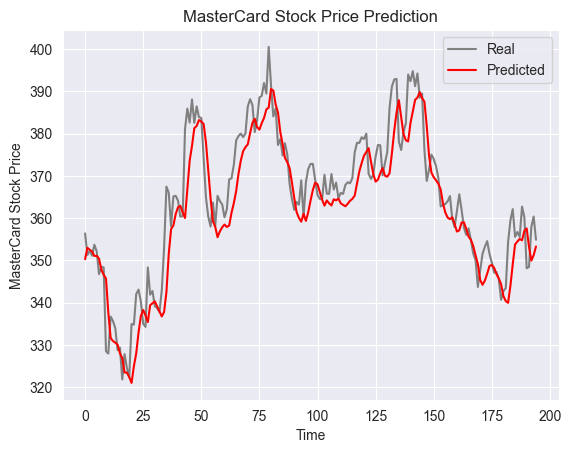

In [48]:
plot_predictions(test_set,predicted_stock_price)

Los resultados parecen prometedores, ya que el modelo obtuvo un rmse reducido en el conjunto de datos de prueba.

In [49]:
print(f"The root mean squared error with 90 n_steps is {np.sqrt(mean_squared_error(test_set, predicted_stock_price)):.2f}.")

The root mean squared error is 7.10.


In [50]:
n_steps = 30
features = 1
# separar en muestras
X_train, y_train = split_sequence(training_set_scaled, n_steps)

In [51]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],features)


In [52]:
# Arquitectura LSTM sencilla
model_lstm = Sequential([
    Input(shape=(n_steps, features)),
    LSTM(units=125, activation="tanh"),
    Dense(units=1)
])

model_lstm.compile(optimizer="RMSprop", loss="mse")
model_lstm.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 125)            │        63,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           126 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,626 (248.54 KB)

 Trainable params: 63,626 (248.54 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0294
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0034
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0027
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0025
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0021
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0019
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0017
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0016
Epoch 9/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0014
Epoch 10/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0013
Epoch 11/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0013
Epoch 12/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0012
Epoch 13/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0011
Epoch 14/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0011
Epoch 15/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0010
Epoc

In [54]:
dataset_total = dataset.loc[:,"High"]
inputs = dataset_total[len(dataset_total) - len(test_set) - n_steps :].values
inputs = inputs.reshape(-1, 1)
# escalado
inputs = sc.transform(inputs)

# separar en muestras
X_test, y_test = split_sequence(inputs, n_steps)
# redimensionar
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)
# predicción
predicted_stock_price = model_lstm.predict(X_test)

# transformada inversa
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


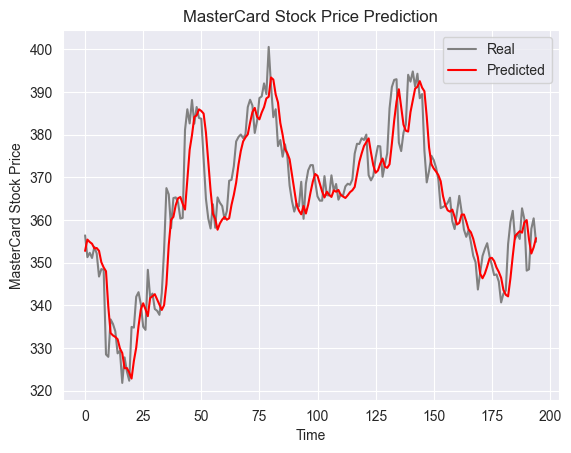

In [55]:
plot_predictions(test_set,predicted_stock_price)

In [56]:
print(f"The root mean squared error with 30 n_steps is {np.sqrt(mean_squared_error(test_set, predicted_stock_price)):.2f}.")

The root mean squared error is 6.40.
